# Recognizing hand-written digits with neural networks

**Neural network Python libraries**
- *Keras*: High level library based on Tensorflow (or others) that is easy to use and flexible enough for most standard users. It has a great documentation and online support. 
- *Tensorflow*: Google's neural network library. Most widely used in ML research. Flexible and powerful but also (unnecessarily?) complicated.
- *Pytorch*: The newcomer developed by Facebook. Flexible like Tensorflow but with a nicer, more Pythonic API.

In this notebook we will tackle a classification task, recognizing hand-written digits of the famous MNIST dataset.

In [1]:
%matplotlib inline
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

## MNIST - Preparing and exploring the data

Keras has a handy function to download the entire MNIST dataset which consists of 60,000 training images and 10000 test images.

In [2]:
(x_trn, y_trn), (x_test, y_test) = keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


In [3]:
x_trn.shape, y_trn.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

**STOP!** What are training, validation and test sets?

- Training set: Data used to optimize the machine learning algorithm
- Validation set: Data used to independently verify the skill of the algorithm
- Test set: Another independent set used for *final* verification.

Let's make a validation set.

In [4]:
# Set a random seed to make train/valid split reproducible
np.random.seed(42)

In [5]:
x_trn, x_val, y_trn, y_val = train_test_split(x_trn, y_trn, test_size=0.2)

In [6]:
x_trn.shape, x_val.shape

((48000, 28, 28), (12000, 28, 28))

In [7]:
def plots(xs, ys):
    nfigs = xs.shape[0]; ncols = min(3, nfigs); nrows = int(np.floor(nfigs / ncols))
    fig, axs = plt.subplots(nrows, ncols, figsize=(3*ncols, 3*nrows))
    for i, ax in enumerate(axs.flat):
        ax.imshow(xs[i], cmap='gray')
        ax.set_title(str(ys[i]))
        ax.set_xticks([]); ax.set_yticks([])

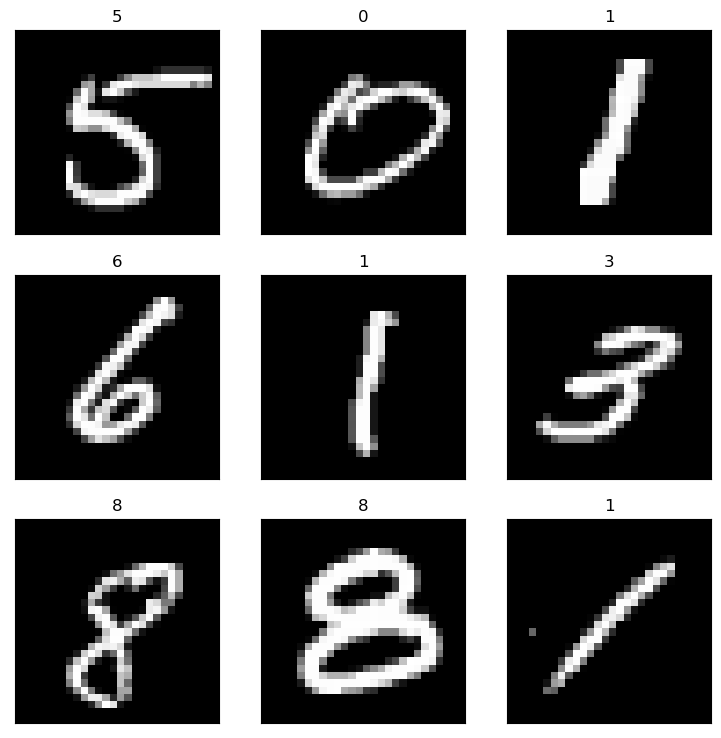

In [8]:
plots(x_trn[:9], y_trn[:9])

For gradient descent to work efficiently it is important that all the input variables or features are roughly on the same order of magnitude. Typically, we try to get them around 1.

In [9]:
def normalize(x): return x / 255

In [10]:
x_trn = normalize(x_trn)
x_val = normalize(x_val)

In [11]:
x_trn[0, 12:15, 12:15]

array([[0.99215686, 0.99215686, 0.76862745],
       [0.85098039, 0.98431373, 0.99215686],
       [0.        , 0.20784314, 0.9254902 ]])

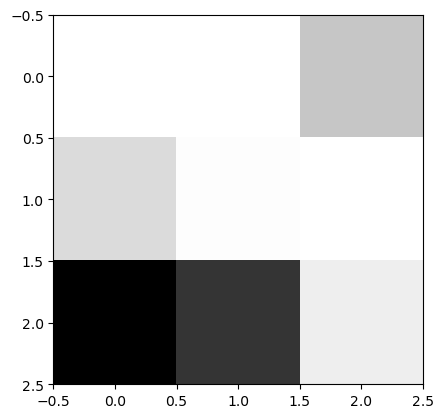

In [12]:
plt.imshow(x_trn[0, 12:15, 12:15], cmap='gray');

Now we will do something pretty dumb. We will flatten out the images and throw away all spatial information.

In [13]:
def flatten(x): return x.reshape(x.shape[0], -1)

In [14]:
x_trn = flatten(x_trn)
x_val = flatten(x_val)

In [15]:
x_trn.shape

(48000, 784)

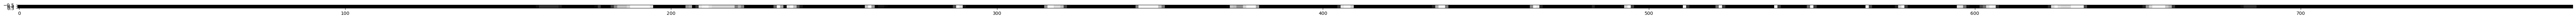

In [16]:
fig = plt.figure(figsize=(100, 1))
plt.imshow(x_trn[0, None, :], cmap='gray');

We are dealing with a classification problem. That means that the correct answer to always one of 10 classes. To pass the numbers to the neural net we one-hot encode the labels.

In [17]:
yoh_trn = to_categorical(y_trn)
yoh_val = to_categorical(y_val)

In [18]:
y_trn[:3], yoh_trn[:3]

(array([5, 0, 1], dtype=uint8),
 array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32))

## Training a simple linear network

To start, let's train a simple linear network.

In [19]:
linear_model = Sequential([
    Dense(10, input_shape=(784,), activation='softmax'),
])

2022-09-21 15:31:37.379255: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


After the matrix multiplication we are using a Softmax layer.

In [20]:
def softmax(x):
    np.exp(x) / np.sum(np.exp(x))

In [21]:
x = [2, 6, 3, 5]

In [22]:
np.exp(x)

array([  7.3890561 , 403.42879349,  20.08553692, 148.4131591 ])

In [23]:
out = np.exp(x) / np.sum(np.exp(x))
out, out.sum()

(array([0.01275478, 0.69638749, 0.03467109, 0.25618664]), 1.0)

Next we need to judge how good our predictions is. For classification we use the categorical crossentropy:

$L = - \sum_c y_t^c \log(y_p^c)$

$c$ is the class, so one of our ten numbers.

In [24]:
linear_model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

In [25]:
linear_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [26]:
linear_model.fit(x_trn, yoh_trn, batch_size=512, epochs=10, validation_data=(x_val, yoh_val))

Epoch 1/10
94/94 [==============================] - 0s 3ms/step - loss: 1.2841 - accuracy: 0.6735 - val_loss: 0.7472 - val_accuracy: 0.8315
Epoch 2/10
94/94 [==============================] - 0s 2ms/step - loss: 0.6158 - accuracy: 0.8563 - val_loss: 0.5290 - val_accuracy: 0.8695
Epoch 3/10
94/94 [==============================] - 0s 2ms/step - loss: 0.4825 - accuracy: 0.8791 - val_loss: 0.4460 - val_accuracy: 0.8860
Epoch 4/10
94/94 [==============================] - 0s 2ms/step - loss: 0.4220 - accuracy: 0.8903 - val_loss: 0.4020 - val_accuracy: 0.8951
Epoch 5/10
94/94 [==============================] - 0s 2ms/step - loss: 0.3867 - accuracy: 0.8976 - val_loss: 0.3734 - val_accuracy: 0.9038
Epoch 6/10
94/94 [==============================] - 0s 2ms/step - loss: 0.3632 - accuracy: 0.9030 - val_loss: 0.3541 - val_accuracy: 0.9078
Epoch 7/10
94/94 [==============================] - 0s 2ms/step - loss: 0.3462 - accuracy: 0.9061 - val_loss: 0.3404 - val_accuracy: 0.9106
Epoch 8/10
94/94 [==

In [27]:
preds = linear_model.predict(x_val, 4096)

3/3 [==============================] - 0s 2ms/step


In [28]:
preds[:3]

array([[4.26923252e-05, 2.75246362e-06, 6.45465025e-06, 6.76466757e-03,
        4.51489905e-04, 5.15809690e-04, 1.29256905e-05, 9.85740840e-01,
        2.14161561e-03, 4.32076445e-03],
       [1.29225271e-04, 2.49533082e-06, 1.24960832e-04, 9.97798860e-01,
        3.06820903e-06, 1.63070287e-03, 2.67268479e-05, 7.09658366e-07,
        2.36515349e-04, 4.68056423e-05],
       [2.19915668e-03, 1.48081884e-03, 2.33716215e-03, 2.49240212e-02,
        3.25820845e-04, 5.03865778e-02, 6.90515953e-05, 1.43472294e-04,
        9.09490168e-01, 8.64378549e-03]], dtype=float32)

In [29]:
num_preds = np.argmax(preds, axis=1); num_preds[:3]

array([7, 3, 8])

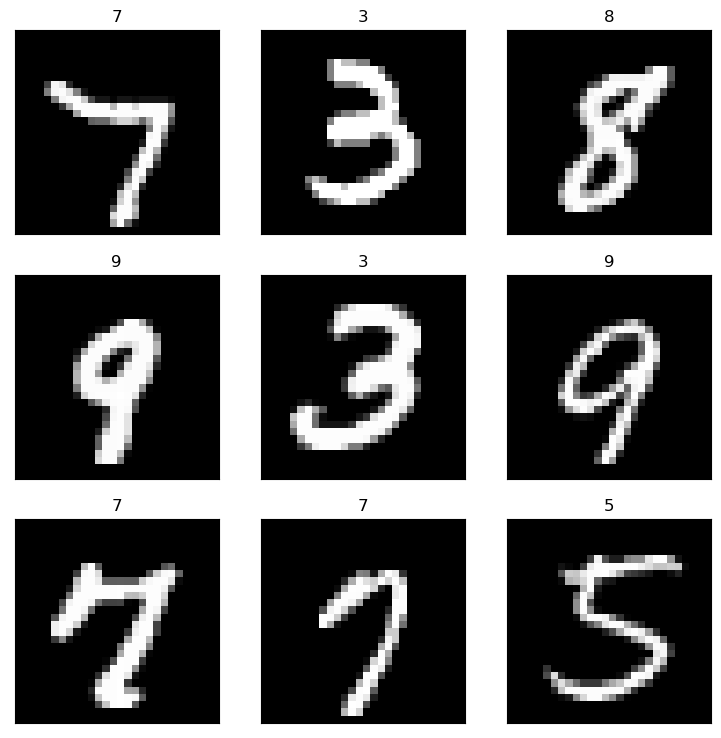

In [30]:
plots(x_val[:9].reshape(-1, 28, 28), num_preds[:9])

## A neural network

A neural network consists of several layers, connected by matrix multiplications. Layers between the input and output layer are called hidden layers. The activations in these layers are passed through a non-linear activation function.

Neural networks can approximate any non-linear function: http://neuralnetworksanddeeplearning.com/chap4.html

In [31]:
neural_net = Sequential([
    Dense(512, input_shape=(784,), activation='relu'),
    Dense(10, activation='softmax'),
])

In [32]:
neural_net.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

In [33]:
neural_net.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 512)               401920    
                                                                 
 dense_2 (Dense)             (None, 10)                5130      
                                                                 
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


In [34]:
neural_net.fit(x_trn, yoh_trn, batch_size=512, epochs=10, validation_data=(x_val, yoh_val))

Epoch 1/10
94/94 [==============================] - 1s 7ms/step - loss: 0.4618 - accuracy: 0.8715 - val_loss: 0.2334 - val_accuracy: 0.9350
Epoch 2/10
94/94 [==============================] - 1s 7ms/step - loss: 0.1983 - accuracy: 0.9450 - val_loss: 0.1732 - val_accuracy: 0.9509
Epoch 3/10
94/94 [==============================] - 1s 7ms/step - loss: 0.1421 - accuracy: 0.9604 - val_loss: 0.1363 - val_accuracy: 0.9606
Epoch 4/10
94/94 [==============================] - 1s 6ms/step - loss: 0.1099 - accuracy: 0.9700 - val_loss: 0.1165 - val_accuracy: 0.9672
Epoch 5/10
94/94 [==============================] - 1s 6ms/step - loss: 0.0876 - accuracy: 0.9762 - val_loss: 0.1028 - val_accuracy: 0.9700
Epoch 6/10
94/94 [==============================] - 1s 6ms/step - loss: 0.0717 - accuracy: 0.9808 - val_loss: 0.0958 - val_accuracy: 0.9712
Epoch 7/10
94/94 [==============================] - 1s 6ms/step - loss: 0.0597 - accuracy: 0.9841 - val_loss: 0.0874 - val_accuracy: 0.9759
Epoch 8/10
94/94 [==

### Deep neural networks

In [35]:
deep_net = Sequential([
    Dense(512, input_shape=(784,), activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax'),
])

In [36]:
deep_net.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

In [37]:
deep_net.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 512)               401920    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               65792     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 10)               

In [38]:
deep_net.fit(x_trn, yoh_trn, batch_size=512, epochs=10, validation_data=(x_val, yoh_val))

Epoch 1/10
94/94 [==============================] - 1s 12ms/step - loss: 0.5593 - accuracy: 0.8275 - val_loss: 0.1793 - val_accuracy: 0.9469
Epoch 2/10
94/94 [==============================] - 1s 11ms/step - loss: 0.1948 - accuracy: 0.9421 - val_loss: 0.1226 - val_accuracy: 0.9626
Epoch 3/10
94/94 [==============================] - 1s 12ms/step - loss: 0.1374 - accuracy: 0.9586 - val_loss: 0.1029 - val_accuracy: 0.9688
Epoch 4/10
94/94 [==============================] - 1s 11ms/step - loss: 0.1038 - accuracy: 0.9691 - val_loss: 0.0904 - val_accuracy: 0.9719
Epoch 5/10
94/94 [==============================] - 1s 11ms/step - loss: 0.0854 - accuracy: 0.9746 - val_loss: 0.0788 - val_accuracy: 0.9764
Epoch 6/10
94/94 [==============================] - 1s 11ms/step - loss: 0.0744 - accuracy: 0.9774 - val_loss: 0.0786 - val_accuracy: 0.9766
Epoch 7/10
94/94 [==============================] - 1s 11ms/step - loss: 0.0653 - accuracy: 0.9804 - val_loss: 0.0761 - val_accuracy: 0.9772
Epoch 8/10
94

In [39]:
deep_net.optimizer.lr=1e-4
deep_net.fit(x_trn, yoh_trn, batch_size=512, epochs=10, validation_data=(x_val, yoh_val))

Epoch 1/10
94/94 [==============================] - 1s 11ms/step - loss: 0.0316 - accuracy: 0.9900 - val_loss: 0.0670 - val_accuracy: 0.9825
Epoch 2/10
94/94 [==============================] - 1s 11ms/step - loss: 0.0255 - accuracy: 0.9922 - val_loss: 0.0656 - val_accuracy: 0.9834
Epoch 3/10
94/94 [==============================] - 1s 11ms/step - loss: 0.0231 - accuracy: 0.9926 - val_loss: 0.0660 - val_accuracy: 0.9829
Epoch 4/10
94/94 [==============================] - 1s 11ms/step - loss: 0.0224 - accuracy: 0.9928 - val_loss: 0.0651 - val_accuracy: 0.9836
Epoch 5/10
94/94 [==============================] - 1s 11ms/step - loss: 0.0212 - accuracy: 0.9933 - val_loss: 0.0664 - val_accuracy: 0.9837
Epoch 6/10
94/94 [==============================] - 1s 11ms/step - loss: 0.0194 - accuracy: 0.9941 - val_loss: 0.0672 - val_accuracy: 0.9839
Epoch 7/10
94/94 [==============================] - 1s 11ms/step - loss: 0.0182 - accuracy: 0.9945 - val_loss: 0.0670 - val_accuracy: 0.9835
Epoch 8/10
94

## Convolutions

To take advantage of the spatial information in images we can use convolutions rather than fully connected layers.

http://setosa.io/ev/image-kernels/

In [40]:
conv_net = Sequential([
    Conv2D(32, kernel_size=5, strides=2, activation='relu', padding='same', input_shape=(28, 28, 1)),
    Conv2D(64, kernel_size=3, strides=2, activation='relu', padding='same'),
    Conv2D(128, kernel_size=3, strides=2, activation='relu', padding='same'),
    Conv2D(10, kernel_size=3, strides=2, padding='same'),
    GlobalAveragePooling2D(),
    Activation('softmax')
])

In [41]:
conv_net.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 10)          11530     
                                                                 
 global_average_pooling2d (G  (None, 10)               0         
 lobalAveragePooling2D)                                          
                                                                 
 activation (Activation)     (None, 10)                0         
                                                      

In [42]:
conv_net.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

In [ ]:
conv_net.fit(x_trn.reshape(-1, 28, 28, 1), yoh_trn, batch_size=512, epochs=20, 
             validation_data=(x_val.reshape(-1, 28, 28, 1), yoh_val))

Epoch 1/20
94/94 [==============================] - 5s 46ms/step - loss: 0.7986 - accuracy: 0.7574 - val_loss: 0.3172 - val_accuracy: 0.9059
Epoch 2/20
94/94 [==============================] - 4s 44ms/step - loss: 0.2577 - accuracy: 0.9236 - val_loss: 0.1987 - val_accuracy: 0.9430
Epoch 3/20
94/94 [==============================] - 4s 43ms/step - loss: 0.1730 - accuracy: 0.9486 - val_loss: 0.1392 - val_accuracy: 0.9598
Epoch 4/20
94/94 [==============================] - 4s 43ms/step - loss: 0.1245 - accuracy: 0.9625 - val_loss: 0.1126 - val_accuracy: 0.9682
Epoch 5/20
94/94 [==============================] - 4s 44ms/step - loss: 0.1013 - accuracy: 0.9691 - val_loss: 0.0932 - val_accuracy: 0.9741
Epoch 6/20
94/94 [==============================] - 4s 43ms/step - loss: 0.0836 - accuracy: 0.9743 - val_loss: 0.0908 - val_accuracy: 0.9747
Epoch 7/20
94/94 [==============================] - 4s 43ms/step - loss: 0.0705 - accuracy: 0.9784 - val_loss: 0.0763 - val_accuracy: 0.9771
Epoch 8/20
94

## End